# LSTM



In [1]:
%config IPCompleter.greedy=True
%matplotlib inline

import sys
sys.path.append('..')

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from metrics import calc_tdi_tdm, squared_error, absolute_error
from evaluation import Evaluation, Result
from datasets import get_dataset
from models.lstm import run_lstm_model
from models.gru import run_gru_model

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
result = pickle.load(open('../results/traffic_test.pickle',"rb"))

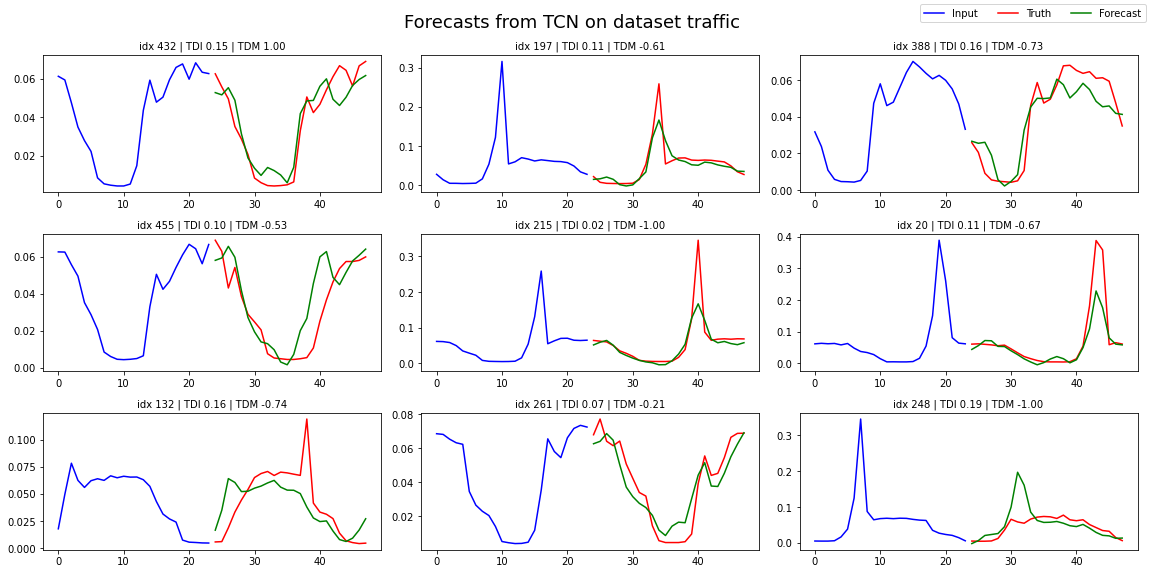

In [4]:
result[0].plot_forecasts(figsize=(16, 8))

# Dataset: ECG5000

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
in_size = 24
out_size = 24
test_size = 500

batch_size = 10
epochs = 20
lr = 0.01

In [5]:
train, test = get_dataset('mvdata', 'traffic', in_size, out_size, test_size)
train_dl = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
test_dl = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)

In [6]:
run_lstm_model(train_dl, test_dl, out_size, epochs)

Training LSTM model:   0%|                                                                                                                                                                                                   | 0/20 [00:00<?, ?epoch/s]


torch.Size([10, 1, 1])


RuntimeError: Expected hidden[0] size (2, 10, 128), got [10, 128]

In [11]:
class LSTM(nn.Module):
    def __init__(self, hidden_size=128, num_layers=1):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=0.2, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, out_features=int(hidden_size / 2))
        self.bn1 = nn.BatchNorm1d(int(hidden_size / 2))
        self.act1 = nn.ReLU()
        self.estimator = nn.Linear(int(hidden_size / 2), 1)

    def forward(self, x):
        batch_size = x.shape[0]
        hidden_state = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        cell_state = hidden_state

        out, _ = self.lstm(x, (hidden_state, cell_state))
        print(out.shape)
        
        out = out.contiguous().view(-1, self.hidden_size)
        out = self.fc1(out)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.estimator(out)

        return out

def train_model(model, optimizer, loss_fn, train_loader, epochs, clip=0):
    """Training loop NetGRU model."""

    model.train()
    train_loss, val_loss, = [], []
    with tqdm(range(epochs), unit="epoch", desc=f"Training GRU model") as pbar:
        for epoch in pbar:

            running_loss, total_cases, = 0, 0  # Running totals
            for seq, target in train_loader:
                seq, target = seq.type(torch.float32).to(device), target.type(torch.float32).to(device)

                # Forward backward
                outputs = model(seq)
                
                print(outputs.shape)
                print(target.shape)
                
                loss = loss_fn(target, outputs)
                optimizer.zero_grad()
                loss.backward()
                if clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                optimizer.step()
                running_loss += loss.item()
                total_cases += len(seq)
            train_loss.append(running_loss / total_cases)
            pbar.set_postfix(train_loss=train_loss[epoch])
    plt.plot(train_loss, 'b', label='Training loss')
    plt.title('Loss history')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
model = LSTM().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

train_model(model, optimizer, loss_fn, train_dl, epochs=epochs)

Training GRU model:   0%|                                                                                                                                                                                                    | 0/20 [00:00<?, ?epoch/s]

torch.Size([10, 24, 128])
torch.Size([240, 1])
torch.Size([10, 24, 1])


RuntimeError: The size of tensor a (24) must match the size of tensor b (240) at non-singleton dimension 1